In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fftpack

import librosa
import librosa.display as ld

from tqdm import tqdm

In [2]:
from utils.config import load_config
from data.load.data_loader import get_codecfake_audio_id_list, load_audio_data

In [3]:
config    = load_config()
cache_dir = config['data_paths']['codecfake']['cache_files']

In [4]:
audio_ids = get_codecfake_audio_id_list()

In [5]:
iterable_ds = load_audio_data(
    audio_ids=audio_ids[:500],
    dataset='codecfake',
    cache_dir=cache_dir
)

In [6]:
rows = []
for audio in iterable_ds:
    audio_id  = audio['audio_id']
    audio_arr = audio['audio']['array']
    srate     = audio['audio']['sampling_rate']
    real_fake = audio['real_or_fake']

    rows.append({
        'audio_id': audio_id,
        'audio_arr': audio_arr,
        'srate': srate,
        'real_or_fake': real_fake
    })

In [7]:
df = pd.DataFrame(rows)
df

,audio_id,audio_arr,srate,real_or_fake
0,p225_002,"[-0.0045166015625, -0.00665283203125, -0.00607...",48000,R
1,p225_002,"[0.001953125, 0.001556396484375, 0.00164794921...",16000,F03
2,p225_002,"[-0.001220703125, -0.001129150390625, -0.00103...",24000,F04
3,p225_002,"[0.001861572265625, 0.001922607421875, 0.00195...",16000,F01
4,p225_002,"[-0.00335693359375, -0.0032958984375, -0.00320...",48000,F05
...,...,...,...,...
3495,p227_037,"[3.0517578125e-05, 0.00018310546875, 0.0003662...",48000,R
3496,p227_037,"[-6.103515625e-05, -0.0001220703125, 0.0, -0.0...",48000,F05
3497,p227_037,"[0.0048828125, 0.0048828125, 0.00494384765625,...",16000,F01
3498,p227_037,"[0.001861572265625, 0.001800537109375, 0.00222...",16000,F06


In [26]:
# Function to resample audio
def resample_audio(audio_arr, orig_sr, target_sr=16000):
    return librosa.resample(audio_arr, orig_sr=orig_sr, target_sr=target_sr)

def plot_audio_waveforms(df, audio_id, target_sr=16000, vertical_offset=2):

    # Filter the DataFrame for the given audio_id
    filtered_df = df[(df['audio_id'] == audio_id) & (df['real_or_fake'] != 'F01')]

    # Resample audio and determine the longest duration in seconds
    resampled_signals = []
    max_duration = 0

    for idx, row in filtered_df.iterrows():
        resampled_audio = resample_audio(row['audio_arr'], row['srate'], target_sr=target_sr)
        resampled_signals.append(resampled_audio)
        duration = len(resampled_audio) / target_sr  # Duration in seconds
        if duration > max_duration:
            max_duration = duration

    # Plotting
    plt.figure(figsize=(12, 8))

    for i, resampled_audio in enumerate(resampled_signals):
        # Time vector for the x-axis in seconds
        time = np.linspace(0, len(resampled_audio) / target_sr, len(resampled_audio))
        # Apply vertical offset
        offset_audio = resampled_audio + i * vertical_offset
        # Plot the waveform with vertical offset
        plt.plot(time, offset_audio, label=f"{filtered_df.iloc[i]['real_or_fake']}")

    plt.xlabel('Time (seconds)')
    plt.yticks([])  # Remove y-axis ticks
    plt.gca().yaxis.set_visible(False)  # Hide y-axis
    plt.title(f'Waveforms for audio_id: {audio_id}')
    plt.legend()
    plt.show()

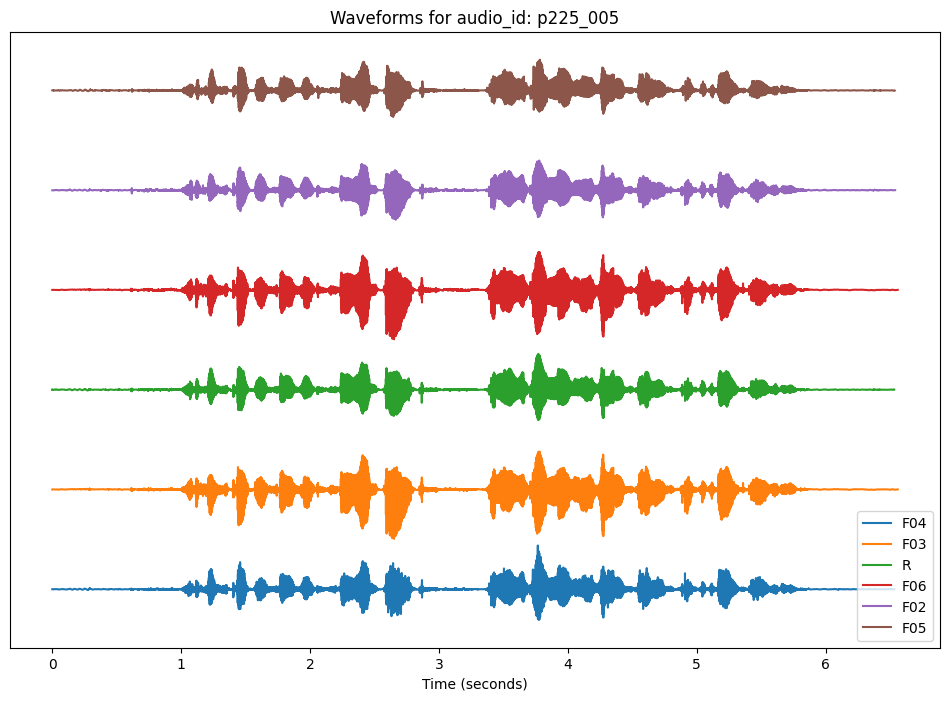

In [27]:
# Select a particular audio_id
audio_id = 'p225_005'
plot_audio_waveforms(df, audio_id)

### Amplitude Spectrum

The amplitude spectrum shows the amplitude of each frequency component present in a signal.

How to Compute:
- Perform a Fourier Transform on the signal to convert it from the time domain to the frequency domain.
- Calculate the amplitude of each frequency component.

**Problems**:
- Linear Scale Limitations: Amplitude values can vary widely, making it difficult to detect small differences between real and fake signals.
- Dynamic Range: It might not effectively highlight smaller variations in amplitude, especially if there are large differences in amplitude across frequencies.
- Noise Sensitivity: The amplitude spectrum can be sensitive to noise, which might obscure subtle differences between real and fake signals.

In [39]:
import scipy.fftpack
import numpy as np

def compute_amplitude_spectrum(signal, srate):
    npnts = len(signal)
    signalX = scipy.fftpack.fft(signal) / npnts  # Normalize by the number of points
    hz = np.linspace(0, srate / 2, int(npnts / 2))  # Frequency axis for positive frequencies
    ampl = 2 * np.abs(signalX[:int(npnts / 2)])  # Normalize and account for positive frequencies
    return hz, ampl

def compute_decibel_spectrum(amplitude_spectrum):
    decibel_spectrum = 20 * np.log10(amplitude_spectrum)
    return decibel_spectrum

def compute_energy_spectrum(amplitude_spectrum):
    energy_spectrum = np.square(amplitude_spectrum)
    return energy_spectrum

def compute_power_spectrum(amplitude_spectrum, npnts):
    power_spectrum = np.square(amplitude_spectrum) / npnts
    return power_spectrum

In [28]:
def plot_amplitude_spectrum(signal, srate, freq_limit=100):
    
    npnts = len(signal)  # Number of points

    # Fourier Transform
    signalX = scipy.fftpack.fft(signal) / npnts  # Normalize by the number of points

    # Frequency axis
    hz = np.linspace(0, srate / 2, int(npnts / 2))  # Frequency axis for positive frequencies

    # Amplitude spectrum
    ampl = 2 * np.abs(signalX[:int(npnts / 2)])  # Normalize and account for positive frequencies

    # Plotting the amplitude spectrum
    plt.figure(figsize=(12, 6))
    plt.stem(hz, ampl, use_line_collection=True)
    plt.xlim(0, freq_limit)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (a.u.)')
    plt.title('Fourier Spectrum')
    plt.show()

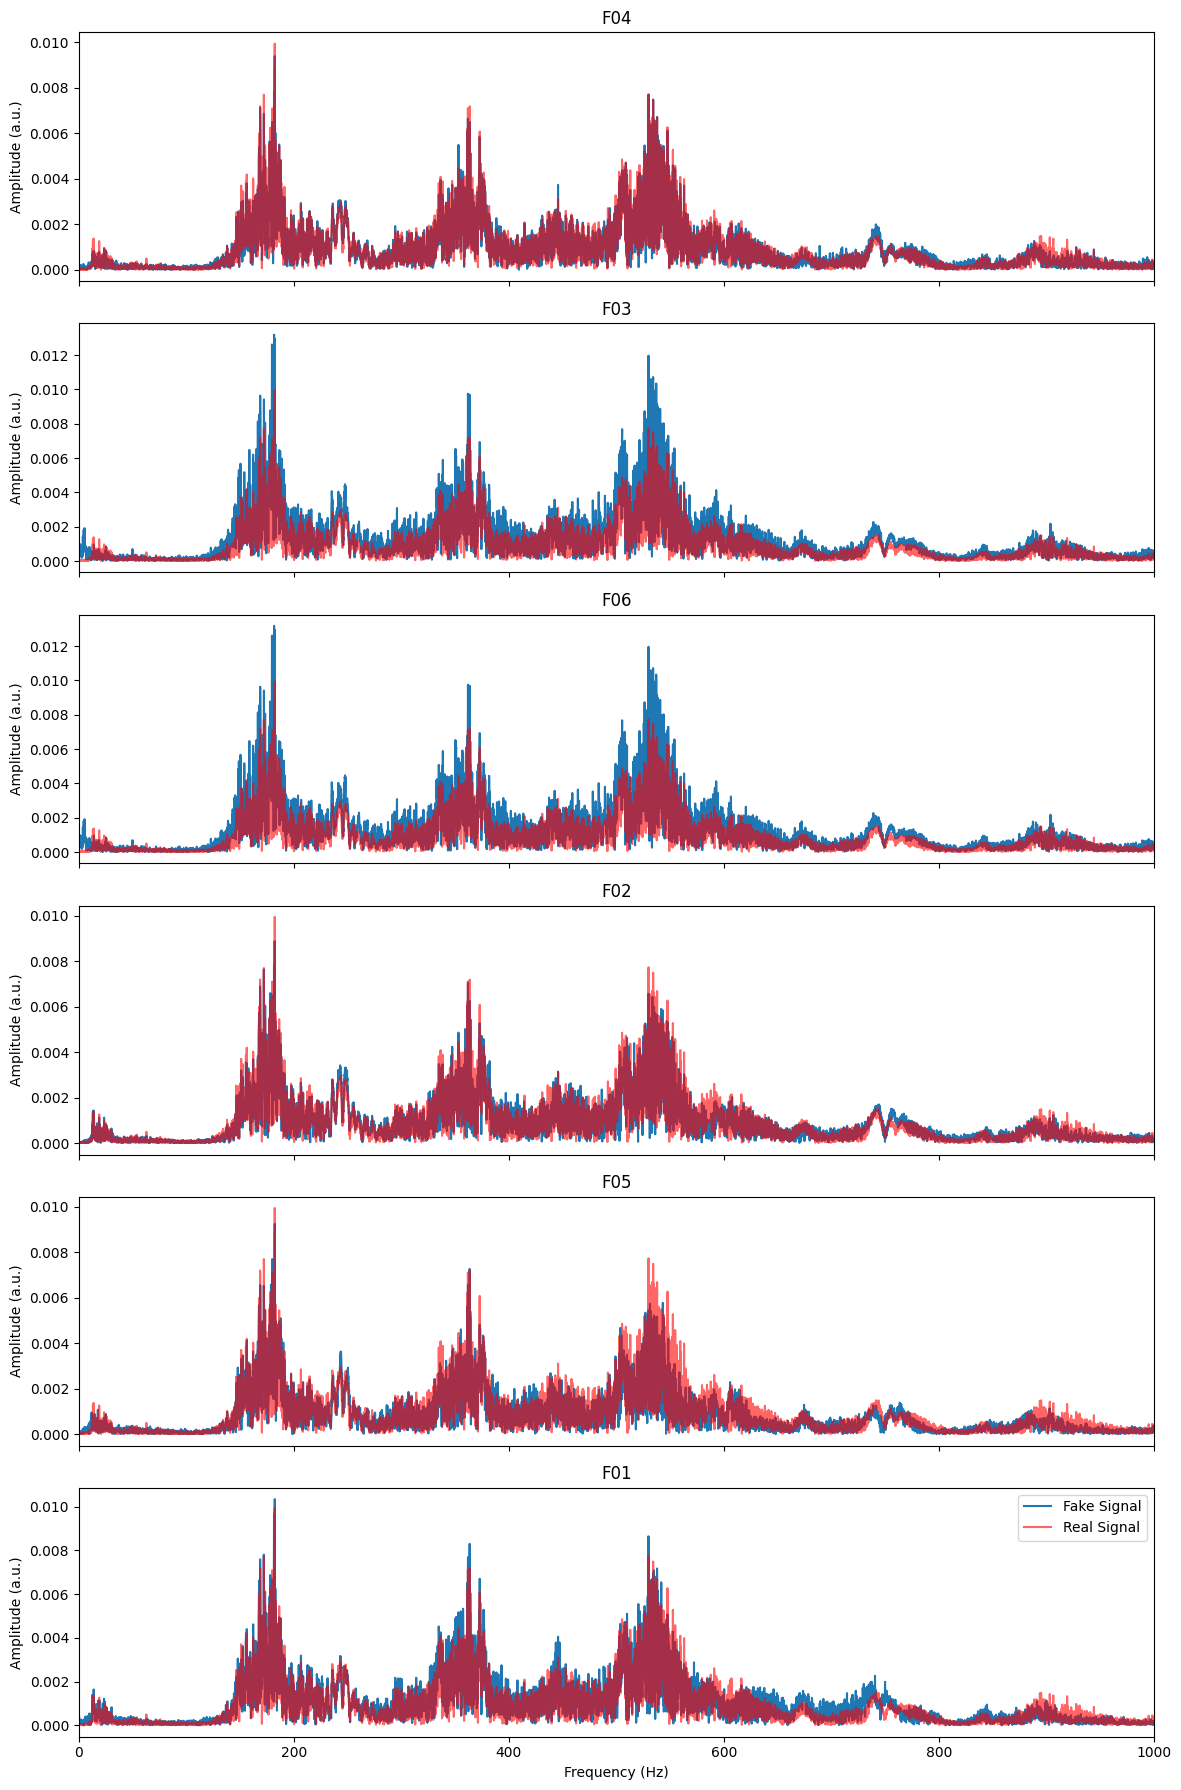

In [32]:
def plot_amplitude_spectra(df, audio_id, target_sr=16000, freq_limit=100, overlay_real=False):
    """
    Plots the amplitude spectra of all resampled signals for a given audio_id in a DataFrame.
    Optionally overlays the spectra of the signal labeled as 'R' on each subplot.

    Parameters:
    df (pd.DataFrame): DataFrame containing audio data with columns 'audio_id', 'audio_arr', 'srate', and 'real_or_fake'.
    audio_id (str): The audio_id to filter and plot.
    target_sr (int): The target sampling rate for resampling the audio. Default is 16000 Hz.
    freq_limit (int): The maximum frequency to display on the x-axis. Default is 100 Hz.
    overlay_real (bool): Whether to overlay the spectra of the signal labeled as 'R'. Default is False.
    """
    # Filter the DataFrame for the given audio_id
    filtered_df = df[df['audio_id'] == audio_id]

    # Separate 'R' and 'F' signals
    real_signal = None
    fake_signals = []

    for idx, row in filtered_df.iterrows():
        resampled_audio = resample_audio(row['audio_arr'], row['srate'], target_sr=target_sr)
        if row['real_or_fake'] == 'R':
            real_signal = (resampled_audio, row['real_or_fake'])
        else:
            fake_signals.append((resampled_audio, row['real_or_fake']))

    # Calculate the amplitude spectrum for the 'R' signal if overlay_real is True
    real_spectrum = None
    if overlay_real and real_signal:
        resampled_audio, _ = real_signal
        npnts = len(resampled_audio)
        signalX = scipy.fftpack.fft(resampled_audio) / npnts  # Normalize by the number of points
        hz = np.linspace(0, target_sr / 2, int(npnts / 2))  # Frequency axis for positive frequencies
        ampl = 2 * np.abs(signalX[:int(npnts / 2)])  # Normalize and account for positive frequencies
        real_spectrum = (hz, ampl)

    # Number of subplots needed
    num_signals = len(fake_signals)

    # Create subplots
    fig, axes = plt.subplots(num_signals, 1, figsize=(12, num_signals * 3), sharex=True)
    if num_signals == 1:
        axes = [axes]

    # Plot each amplitude spectrum in a subplot
    for i, (resampled_audio, label) in enumerate(fake_signals):
        npnts = len(resampled_audio)
        signalX = scipy.fftpack.fft(resampled_audio) / npnts  # Normalize by the number of points
        hz = np.linspace(0, target_sr / 2, int(npnts / 2))  # Frequency axis for positive frequencies
        ampl = 2 * np.abs(signalX[:int(npnts / 2)])  # Normalize and account for positive frequencies

        # axes[i].stem(hz, ampl, markerfmt=' ', basefmt=' ', label='Fake Signal')
        axes[i].plot(hz, ampl, label='Fake Signal')
        axes[i].set_xlim(0, freq_limit)
        axes[i].set_ylabel('Amplitude (a.u.)')
        axes[i].set_title(f'{label}')

        # Overlay the 'R' signal if overlay_real is True
        if overlay_real and real_spectrum:
            real_hz, real_ampl = real_spectrum
            # axes[i].plot(real_hz, real_ampl, 'r', alpha=0.6, label='Real Signal')
            axes[i].plot(real_hz, real_ampl, 'r', alpha=0.6, label='Real Signal')

    # Set common labels
    plt.xlabel('Frequency (Hz)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_amplitude_spectra(df, audio_id, freq_limit=1000, overlay_real=True)

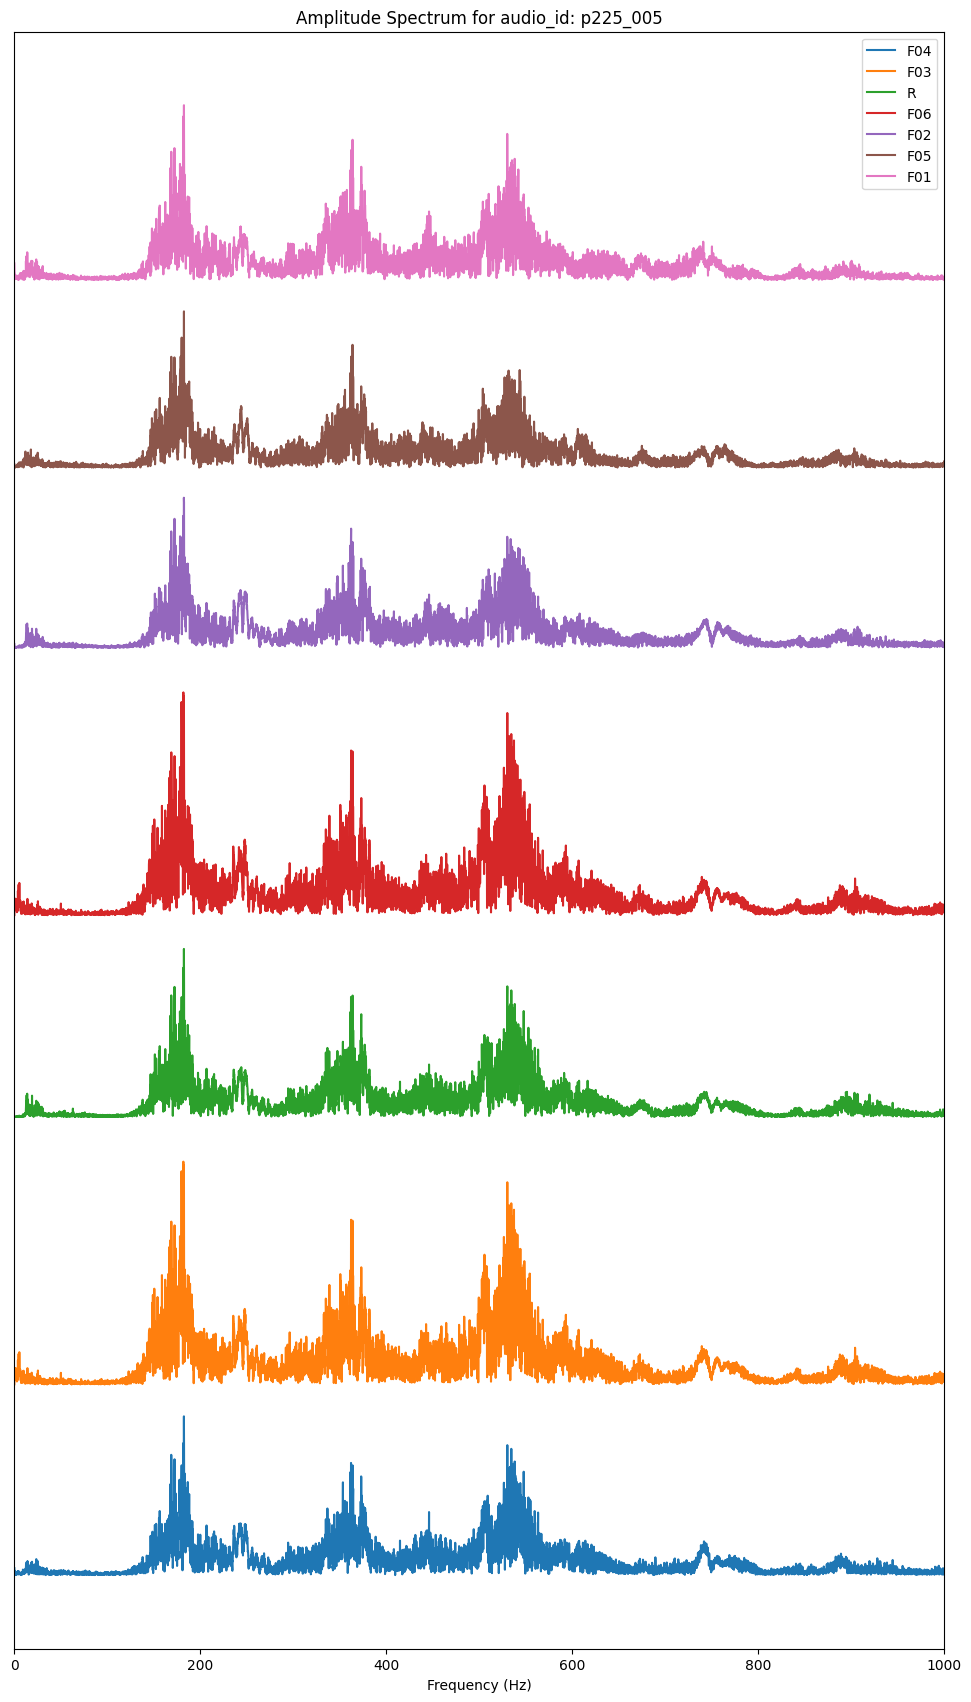

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_spectra_with_offset(df, audio_id, target_sr=16000, freq_limit=50, spectrum_type='amplitude'):
    # Filter the DataFrame for the given audio_id
    filtered_df = df[df['audio_id'] == audio_id]

    # Resample audio and store the results
    resampled_signals = []
    labels = []
    for idx, row in filtered_df.iterrows():
        resampled_audio = resample_audio(row['audio_arr'], row['srate'], target_sr=target_sr)
        resampled_signals.append(resampled_audio)
        labels.append(row['real_or_fake'])

    plt.figure(figsize=(12, len(resampled_signals) * 3))
    vertical_offset = 0

    for i, resampled_audio in enumerate(resampled_signals):
        hz, ampl = compute_amplitude_spectrum(resampled_audio, target_sr)
        
        if spectrum_type == 'amplitude':
            spectrum = ampl
        elif spectrum_type == 'decibel':
            spectrum = compute_decibel_spectrum(ampl)
        elif spectrum_type == 'energy':
            spectrum = compute_energy_spectrum(ampl)
        elif spectrum_type == 'power':
            spectrum = compute_power_spectrum(ampl, len(resampled_audio))
        else:
            raise ValueError(f"Unknown spectrum type: {spectrum_type}")

        plt.plot(hz, spectrum + vertical_offset, label=f'{labels[i]}')
        vertical_offset += max(spectrum) * 1.2  # Adjust the offset based on the maximum amplitude

    plt.xlabel('Frequency (Hz)')
    plt.xlim(0, freq_limit)
    plt.yticks([])  # Remove y-axis ticks
    plt.gca().yaxis.set_visible(False)  # Hide y-axis
    plt.title(f'{spectrum_type.capitalize()} Spectrum for audio_id: {audio_id}')
    plt.legend()
    plt.show()

plot_spectra_with_offset(df, audio_id, freq_limit=1000, spectrum_type='amplitude')

Shows Frequency Distribution: 
The amplitude spectrum effectively displays how different frequencies contribute to the overall signal. 
* It can be useful for identifying dominant frequencies and their strengths.

### Decibel Spectrum

The decibel spectrum represents the amplitude spectrum in a logarithmic scale (decibels).

**Usefulness**:
- Dynamic Range: It highlights smaller variations in amplitude that might be missed on a linear scale.
- Signal Differences: Useful for detecting subtle differences between real and fake audio signals.

**How to compute**:
* Convert the amplitude spectrum to decibels using the formula: dB $= 20\log_{10}$(amplitude)

**Problems**:
- Logarithmic Transform: Applying a logarithmic transform can amplify noise, making it harder to distinguish between real and fake signals if the noise level is significant.
- Negative Values: Decibel values can become negative for very small amplitudes, which can be challenging to interpret.
- Complexity: The logarithmic scale might be less intuitive to understand compared to the linear amplitude spectrum.

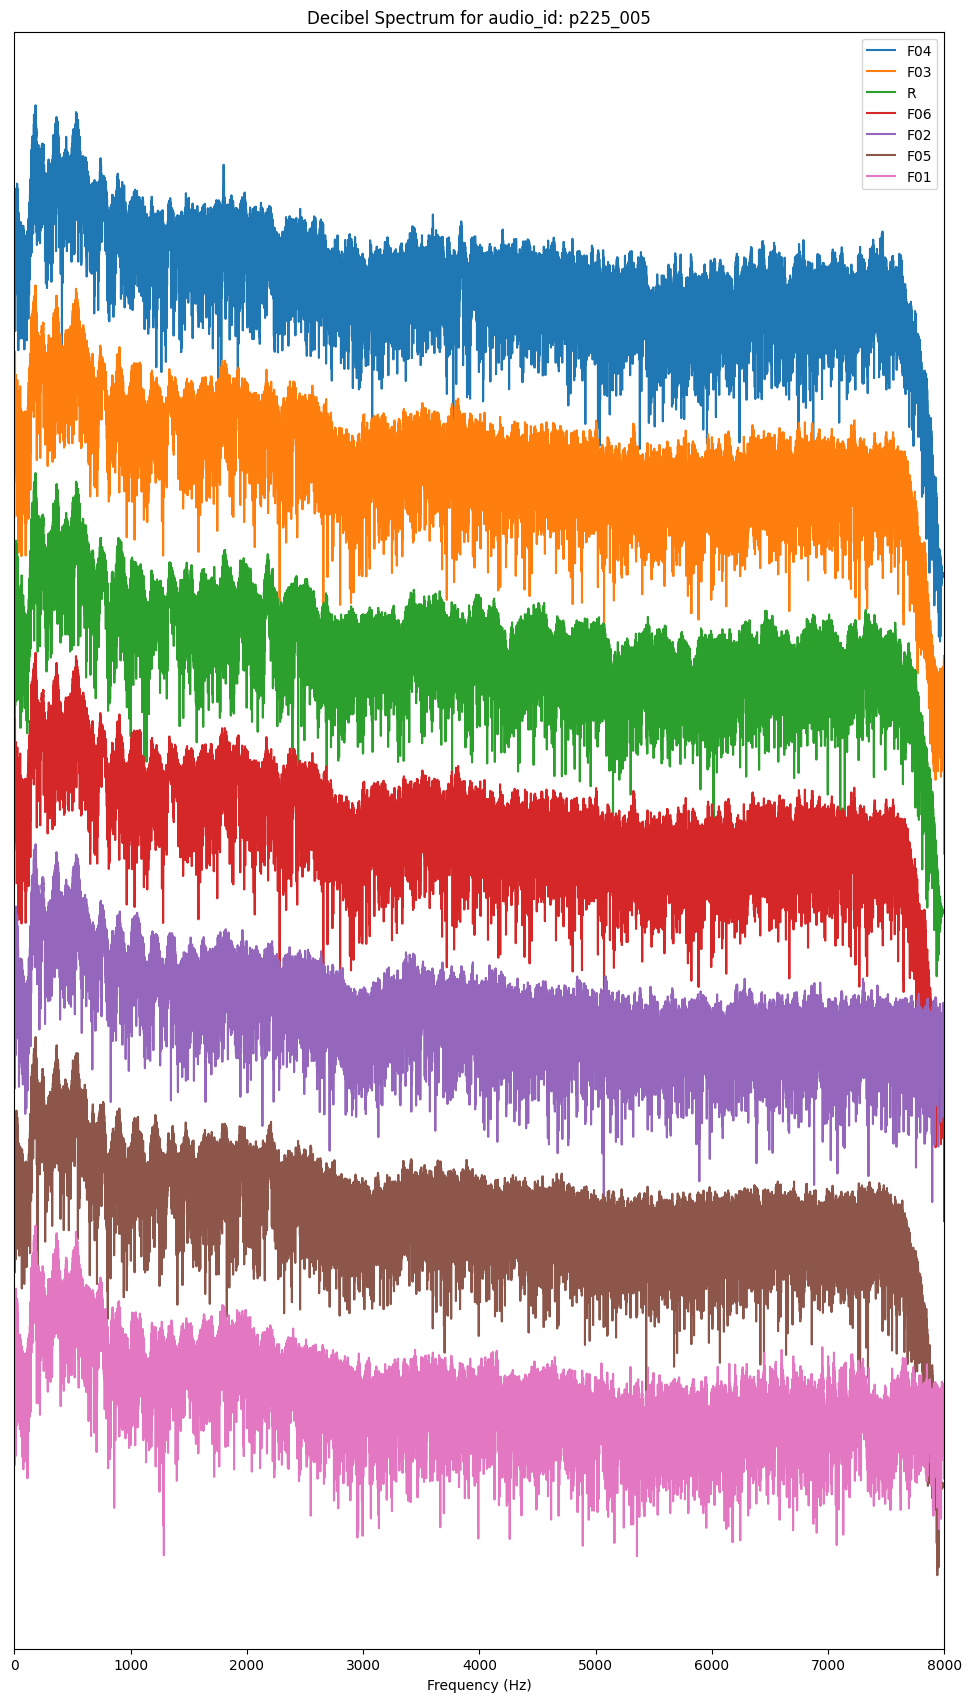

In [42]:
# Plot decibel spectrum with vertical offsets
plot_spectra_with_offset(df, audio_id, freq_limit=8000, spectrum_type='decibel')

### Energy Spectrum

The energy spectrum shows the distribution of the signal's energy across different frequencies.

**Usefulness**:
- Energy Distribution: It provides insight into how the signal's energy is distributed, which can be different for real and fake signals.
- Feature Extraction: Useful for feature extraction in machine learning models.

**How to Compute**:
- Square the amplitude spectrum to get the energy for each frequency component.

**Problems**:
- Noise Influence: Like the amplitude spectrum, the energy spectrum can be sensitive to noise, as noise components contribute to the total energy.
- Normalization: Differences in overall signal energy might obscure frequency-specific differences, requiring careful normalization.
- Dominance by Strong Frequencies: Strong frequency components can dominate the energy spectrum, making it hard to detect differences in weaker components.

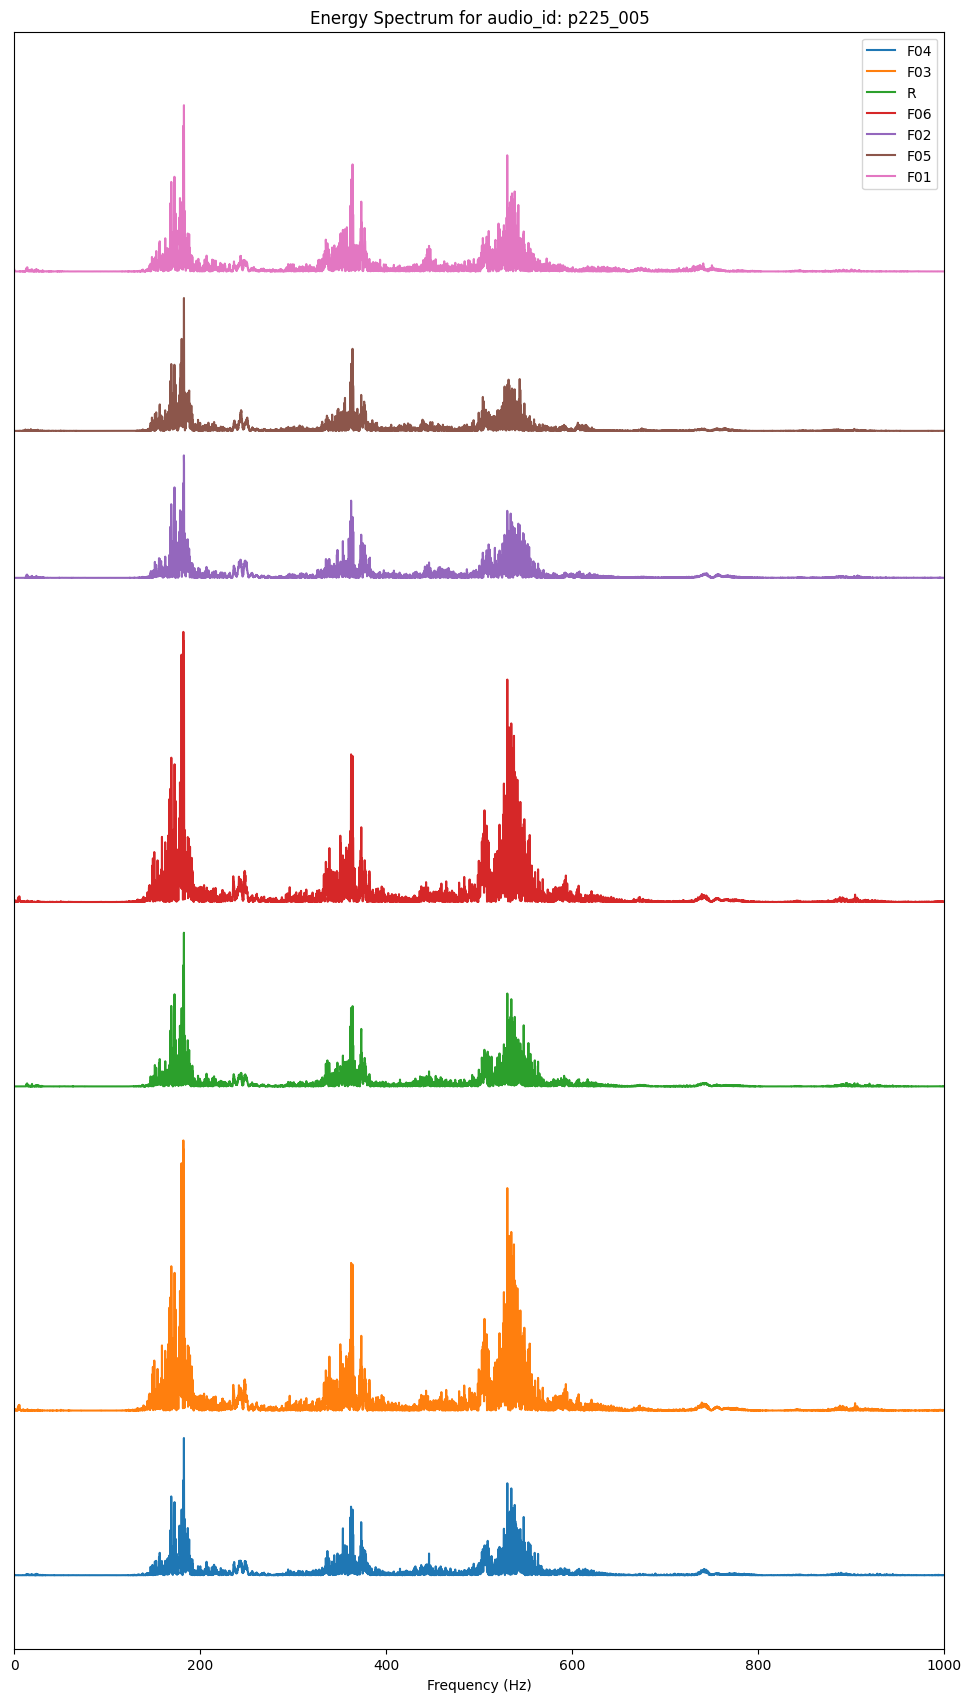

In [43]:
# Plot energy spectrum with vertical offsets
plot_spectra_with_offset(df, audio_id, freq_limit=1000, spectrum_type='energy')

### Power Spectrum

The power spectrum shows the power of the signal at different frequencies, which is the energy per unit time.

**How to Compute**:
- Compute the power by averaging the energy over time. For stationary signals, this can be done by squaring the amplitude spectrum and normalizing by the number of points.

**Problems**:
- Stationarity Assumption: Assumes the signal is stationary, which might not be true for all audio signals, leading to inaccurate power estimates.
- Normalization Issues: Like the energy spectrum, differences in total power can obscure frequency-specific differences.
- Noise Sensitivity: Can be influenced by noise, similar to the amplitude and energy spectra, making it challenging to distinguish between real and fake signals.

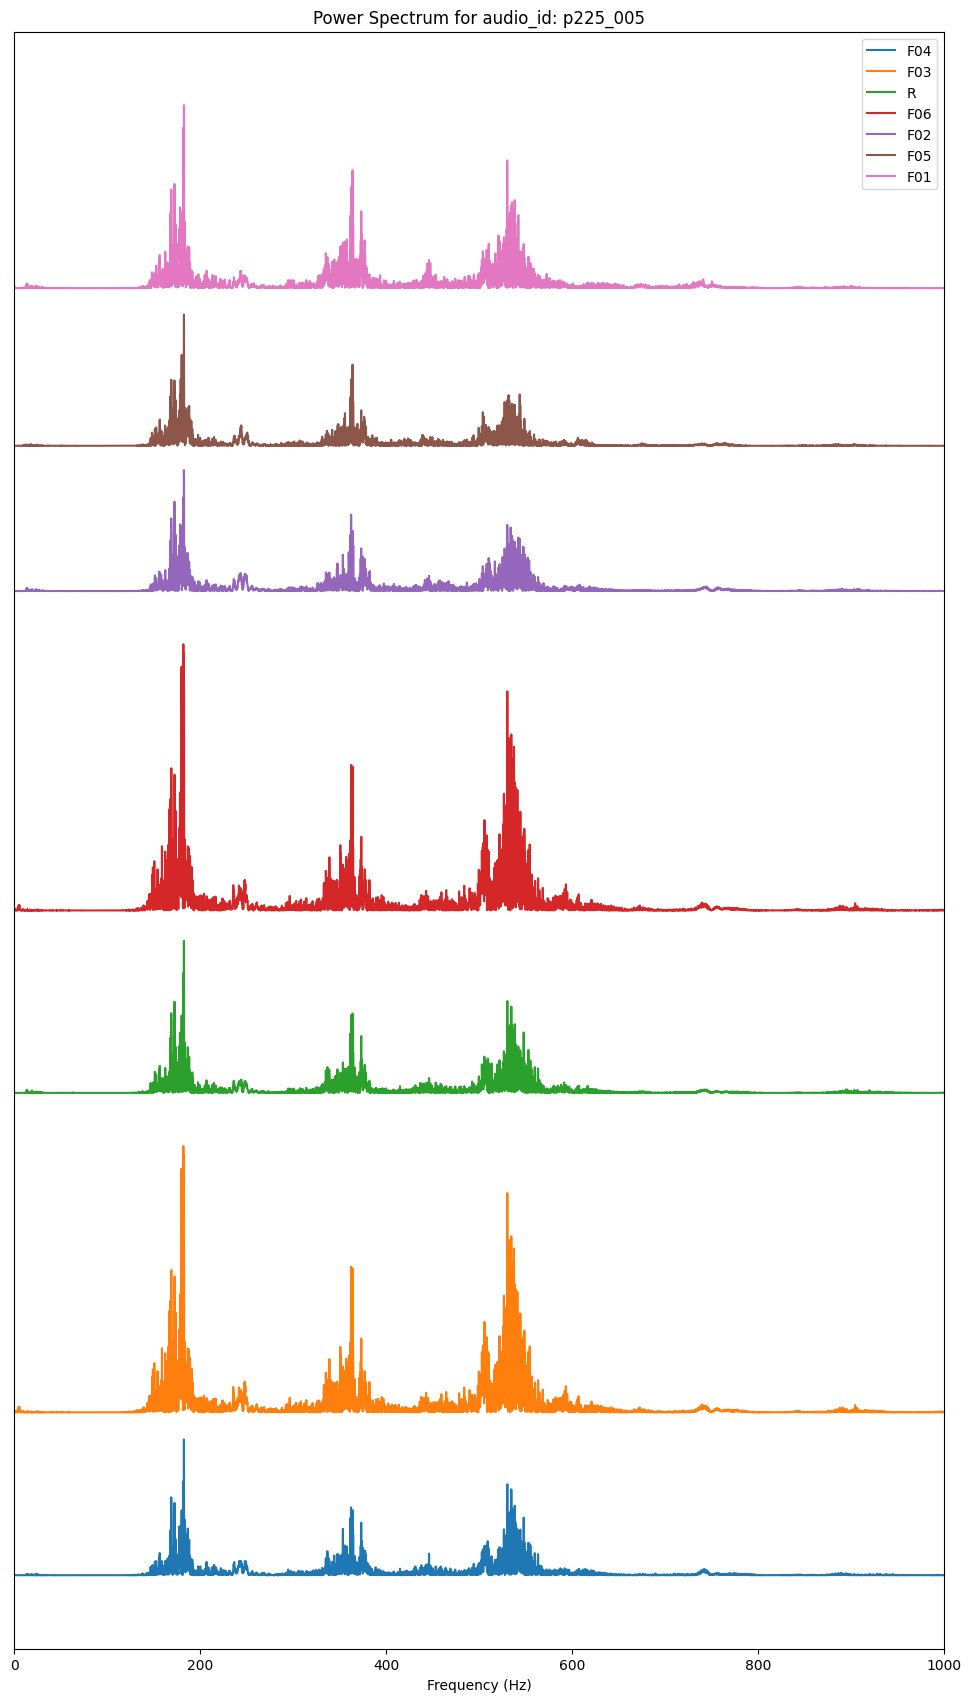

In [44]:
# Plot power spectrum with vertical offsets
plot_spectra_with_offset(df, audio_id, freq_limit=1000, spectrum_type='power')